In [1]:
import sys
sys.path.append('/storage/vbutoi/projects')
sys.path.append('/storage/vbutoi/libraries')
sys.path.append('/storage/vbutoi/projects/ESE')
sys.path.append('/storage/vbutoi/projects/UniverSeg')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style("darkgrid")
sns.set_context("talk")

import os 
os.environ['DATAPATH'] = ':'.join((
       '/storage/vbutoi/datasets',
))

from ese.experiment.analysis.analyze_inf import load_cal_inference_stats
# Results loader object does everything
from ionpy.analysis import ResultsLoader
from pathlib import Path
root = Path("/storage/vbutoi/scratch/ESE")
rs = ResultsLoader()

# For using code without restarting.
%load_ext autoreload
%autoreload 2
# For using yaml configs.
%load_ext yamlmagic

/local/vbutoi/envs/UniverSegTF/lib/python3.9/site-packages/pydantic/_internal/_fields.py:149: UserWarning: Field "model_outputs" has conflict with protected namespace "model_".

You may be able to resolve this warning by setting `model_config['protected_namespaces'] = ()`.
  warnings.warn(


In [2]:
%%yaml results_cfg 

log:
    root: /storage/vbutoi/scratch/ESE/inference
    inference_groups: 
        - '06_17_24_DRIVE_to_STARE_Hard_Training'
        - '06_17_24_DRIVE_to_STARE_SVLS_Training'

options:
    add_dice_loss_rows: True
    drop_nan_metric_rows: True 
    remove_shared_columns: False
    equal_rows_per_cfg_assert: False 

<IPython.core.display.Javascript object>

In [3]:
inference_df = load_cal_inference_stats(
    results_cfg=results_cfg,
    load_cached=False,
)

Dropping (datapoint, metric) pairs with NaN metric score. Dropped from 1980 -> 1980 rows.
Finished loading inference stats.
Log amounts: root                                                                                                       log_set                                              
/storage/vbutoi/scratch/ESE/inference/06_17_24_DRIVE_to_STARE_Hard_Training/STARE_Individual_Uncalibrated  20240617_151409-RLZ5-6823518906156429d408f4a97698e576    216
                                                                                                           20240617_151413-FX7D-f6c12d46151ad79ab19d6ea4ff59c0dd    216
                                                                                                           20240617_151417-3YO4-f6310c19c6660b1a280991a4d588e520    216
                                                                                                           20240617_151421-J5DT-cc09885e7b58c1ae28e9f230cac8e23e    216
                              

In [4]:
# For the purpose of this experiment, we only care about a few columns in particular:
exp_columns = [
    "data_id",
    "gt_volume",
    "hard_volume",
    "soft_volume",
    "pretrained_seed", 
    "pretrained_exp_root",
    "split",
]
# Take these columns of the inference_df, drop other columns.
exp_df = inference_df[exp_columns].drop_duplicates().reset_index(drop=True)

In [5]:
# We need to rename 'volume' to 'area' for the sake of the experiment.
area_df = exp_df.rename(columns={
    "gt_volume": "gt area",
    "hard_volume": "hard area",
    "soft_volume": "soft area",
})

In [6]:
# Make two new columns, one for the soft volume error and one for the hard volume error.
area_df['soft error'] = (area_df['soft area'] - area_df['gt area'])
area_df['hard error'] = (area_df['hard area'] - area_df['gt area'])
# Make the normalized metric that divides the error by the ground truth volume.
area_df['soft relative error'] = area_df['soft error'] / area_df['gt area']
area_df['hard relative error'] = area_df['hard error'] / area_df['gt area']

In [7]:
area_df

,data_id,gt area,hard area,soft area,pretrained_seed,pretrained_exp_root,split,soft error,hard error,soft relative error,hard relative error
0,im0139,2841.419678,1689.0,1869.069336,41,/storage/vbutoi/scratch/ESE/training/06_14_24_...,train,-972.350342,-1152.419678,-0.342206,-0.405579
1,im0005,1957.156982,1830.0,1995.549072,41,/storage/vbutoi/scratch/ESE/training/06_14_24_...,train,38.392090,-127.156982,0.019616,-0.064970
2,im0003,1076.286255,863.0,1129.247314,41,/storage/vbutoi/scratch/ESE/training/06_14_24_...,train,52.961060,-213.286255,0.049207,-0.198169
3,im0077,2364.729492,1681.0,1896.077881,41,/storage/vbutoi/scratch/ESE/training/06_14_24_...,train,-468.651611,-683.729492,-0.198184,-0.289136
4,im0044,2069.317627,1511.0,1628.393677,41,/storage/vbutoi/scratch/ESE/training/06_14_24_...,train,-440.923950,-558.317627,-0.213077,-0.269808
...,...,...,...,...,...,...,...,...,...,...,...
175,im0002,1027.215698,137.0,524.444031,42,/storage/vbutoi/scratch/ESE/training/06_17_24_...,val,-502.771667,-890.215698,-0.489451,-0.866630
176,im0236,2456.698242,804.0,1405.155151,42,/storage/vbutoi/scratch/ESE/training/06_17_24_...,cal,-1051.543091,-1652.698242,-0.428031,-0.672731
177,im0004,1354.976562,20.0,319.576538,42,/storage/vbutoi/scratch/ESE/training/06_17_24_...,cal,-1035.400024,-1334.976562,-0.764146,-0.985240
178,im0162,2145.431396,110.0,754.227417,42,/storage/vbutoi/scratch/ESE/training/06_17_24_...,cal,-1391.203979,-2035.431396,-0.648450,-0.948728


# Library Funcs

In [8]:
def prepare_error_df(raw_df, groupby_keys, value_vars, var_name, value_name):
    # Make a clone of the volume df.
    input_df = raw_df.copy()
    # Melt the dataframe to have a single column for the error.
    error_df = pd.melt(
        input_df,
        id_vars=groupby_keys,
        value_vars=value_vars,
        var_name=var_name,
        value_name=value_name,
    )
    # Make some columns that are useful for plotting.
    error_df[f'absolute {value_name}'] = error_df[value_name].abs()
    # Return the melted dataframe.
    return error_df


def calibrator(pretrained_exp_root):
    if "SVLS" in pretrained_exp_root:
        return "SVLS"
    else:
        return "Uncalibrated"


def process_method_names(input_df, value_name):
    # Make a clone of the input_df
    df = input_df.copy()
    # Drop all the rows where calibrator != Uncalibrated AND the volume_type is hard_volume_error.
    df = df[~((df['calibrator'] != 'Uncalibrated') & (df['area_type'] == f'hard {value_name}'))]
    # Then we augment the volume_type with the calibrator name.
    def area_type(calibrator, area_type):
        if calibrator == "Uncalibrated":
            return "Uncalibrated " + area_type.split(" ")[0]
        else:
            return calibrator + " soft"
    df['area type'] = df.apply(lambda x: area_type(x['calibrator'], x['area_type']), axis=1)
    # Finally, sort by data_id
    df = df.sort_values(by="data_id")
    # Return the augmented dataframe.
    return df

# First, let's look at absolute error.

In [9]:
area_df.augment(calibrator)
# Make some columns that are useful for plotting.
raw_melted_error_df = prepare_error_df(
    area_df, 
    groupby_keys=[
        "calibrator",
        "data_id", 
        "pretrained_seed", 
        "gt area", 
        "soft area", 
        "hard area",
        "split",
    ],
    value_vars=["soft error", "hard error"],
    var_name="area_type",
    value_name="error"
)
# Process the volume types.
melted_error_df = process_method_names(raw_melted_error_df, value_name="error")

In [10]:
melted_error_df['area type'].unique()

array(['Uncalibrated hard', 'SVLS soft', 'Uncalibrated soft'],
      dtype=object)

In [11]:
# Finally, we want to change the order that the methods appear in.
melted_error_df['area type'] = melted_error_df['area type'].astype('category')
melted_error_df['area type'] = melted_error_df['area type'].cat.reorder_categories([
    'Uncalibrated hard',
    'Uncalibrated soft',
    'SVLS soft',
])

# Custom palette dictionary
custom_palette = {
    'Uncalibrated hard': 'blue',
    'Uncalibrated soft': 'limegreen',
    'SVLS soft': 'darkorange'
}

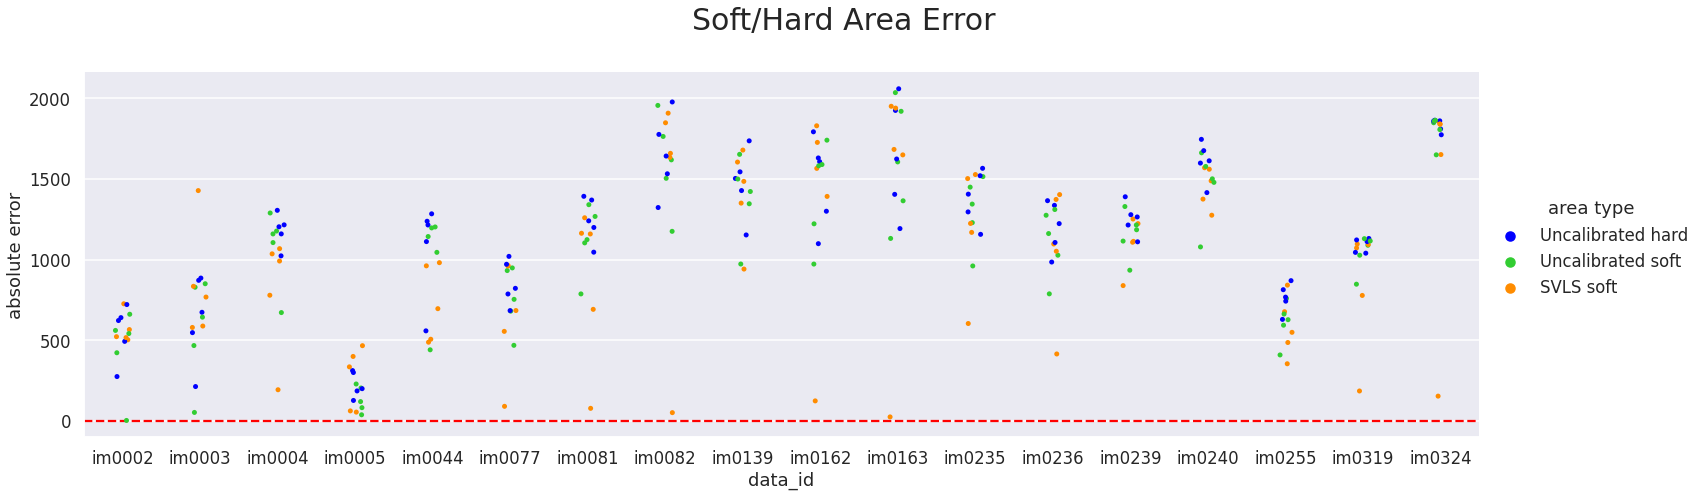

In [12]:
g = sns.catplot(
    melted_error_df,
    x="data_id",
    y="absolute error",
    hue="area type",
    aspect=3,
    height=7,
    sharex=False,
    sharey=False,
    palette=custom_palette
)
# For each subplot make a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0, ls='--', color='red')

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Soft/Hard Area Error', fontsize=30)

# Show the plot
plt.show()

In [13]:
melted_error_df

,calibrator,data_id,pretrained_seed,gt area,soft area,hard area,split,area_type,error,absolute error,area type
211,Uncalibrated,im0002,40,1027.215698,466.223145,387.0,val,hard error,-640.215698,640.215698,Uncalibrated hard
157,SVLS,im0002,44,1027.215698,460.973846,223.0,val,soft error,-566.241852,566.241852,SVLS soft
103,SVLS,im0002,40,1027.215698,504.881836,121.0,val,soft error,-522.333862,522.333862,SVLS soft
85,Uncalibrated,im0002,43,1027.215698,366.018524,306.0,val,soft error,-661.197174,661.197174,Uncalibrated soft
175,SVLS,im0002,42,1027.215698,524.444031,137.0,val,soft error,-502.771667,502.771667,SVLS soft
...,...,...,...,...,...,...,...,...,...,...,...
29,Uncalibrated,im0324,40,1865.125488,59.917137,56.0,train,soft error,-1805.208351,1805.208351,Uncalibrated soft
119,SVLS,im0324,43,1865.125488,26.128374,3.0,train,soft error,-1838.997114,1838.997114,SVLS soft
83,Uncalibrated,im0324,43,1865.125488,2.362908,2.0,train,soft error,-1862.762580,1862.762580,Uncalibrated soft
191,Uncalibrated,im0324,41,1865.125488,216.302582,92.0,train,hard error,-1773.125488,1773.125488,Uncalibrated hard


In [14]:
# We want to calculate now the average (across seeds) of the the absolute error for each method.
# That means first averaging within each seed, then averaging across seeds.
# We group by the data_id and the volume_type.
error_per_seed = melted_error_df.groupby(["pretrained_seed", "area type"]).agg(
    abs_error=("absolute error", "mean"),
).reset_index()
# Rename abs_error to absolute error.
error_per_seed = error_per_seed.rename(columns={"abs_error": "absolute error"})

In [15]:
# make a table with each row being the volume type, and the column being the abs_error mean with standard deviation in another column.
method_error_table = error_per_seed.pivot_table(
    values="absolute error",
    index="area type",
    columns="pretrained_seed",
    aggfunc="mean",
)
# Average across the pretrained seeds to make an average column, and then make a stdv column.
method_error_table['mean'] = method_error_table.mean(axis=1)
method_error_table['stdv'] = method_error_table.std(axis=1)
# We can drop all other columns that aren't mean and stdv
method_error_table = method_error_table[['mean', 'stdv']]

In [16]:
method_error_table

pretrained_seed,mean,stdv
area type,,
Uncalibrated hard,1175.818605,131.904762
Uncalibrated soft,1088.913837,181.900431
SVLS soft,1003.510142,252.378921


## Second, let's look at relative error.

In [17]:
area_df.augment(calibrator)
# Make some columns that are useful for plotting.
raw_melted_relative_df = prepare_error_df(
    area_df, 
    groupby_keys=[
        "calibrator",
        "data_id", 
        "pretrained_seed", 
        "gt area", 
        "soft area", 
        "hard area",
        "split",
    ],
    value_vars=["soft relative error", "hard relative error"],
    var_name="area_type",
    value_name="relative error"
)
# Process the volume types.
melted_relative_df = process_method_names(raw_melted_relative_df, value_name="relative error")

In [18]:
melted_relative_df['area type'].unique()

array(['Uncalibrated hard', 'SVLS soft', 'Uncalibrated soft'],
      dtype=object)

In [19]:
# Finally, we want to change the order that the methods appear in.
melted_relative_df['area type'] = melted_relative_df['area type'].astype('category')
melted_relative_df['area type'] = melted_relative_df['area type'].cat.reorder_categories([
    'Uncalibrated hard',
    'Uncalibrated soft',
    'SVLS soft',
])

# Custom palette dictionary
custom_palette = {
    'Uncalibrated hard': 'blue',
    'Uncalibrated soft': 'limegreen',
    'SVLS soft': 'darkorange'
}

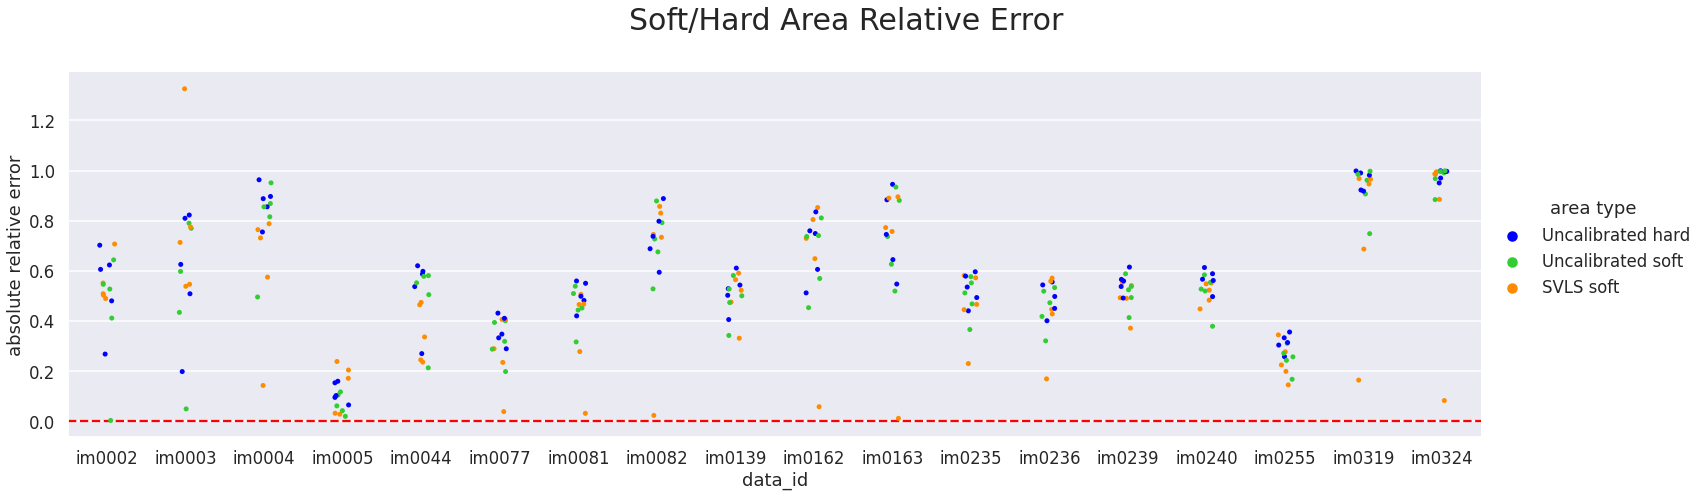

In [20]:
g = sns.catplot(
    melted_relative_df,
    x="data_id",
    y="absolute relative error",
    hue="area type",
    aspect=3,
    height=7,
    sharex=False,
    sharey=False,
    palette=custom_palette
)
# For each subplot make a line at y = 0 to show the error.
for ax in g.axes.flat:
    ax.axhline(0.0, ls='--', color='red')

# Adjust the layout
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Soft/Hard Area Relative Error', fontsize=30)

# Show the plot
plt.show()

In [21]:
# We want to calculate now the average (across seeds) of the the absolute error for each method.
# That means first averaging within each seed, then averaging across seeds.
# We group by the data_id and the volume_type.
relative_per_seed = melted_relative_df.groupby(["pretrained_seed", "area type"]).agg(
    abs_relative_error=("absolute relative error", "mean"),
).reset_index()
# Rename abs_error to absolute error.
relative_per_seed = relative_per_seed.rename(columns={"abs_relative_error": "absolute relative error"})

In [22]:
# make a table with each row being the volume type, and the column being the abs_error mean with standard deviation in another column.
method_relative_table = relative_per_seed.pivot_table(
    values="absolute relative error",
    index="area type",
    columns="pretrained_seed",
    aggfunc="mean",
)
# Average across the pretrained seeds to make an average column, and then make a stdv column.
method_relative_table['mean'] = method_relative_table.mean(axis=1)
method_relative_table['stdv'] = method_relative_table.std(axis=1)
# We can drop all other columns that aren't mean and stdv
method_relative_table = method_relative_table[['mean', 'stdv']]

In [23]:
method_relative_table

pretrained_seed,mean,stdv
area type,,
Uncalibrated hard,0.588961,0.070396
Uncalibrated soft,0.544072,0.098820
SVLS soft,0.506989,0.116642
